<a href="https://colab.research.google.com/github/mimi-1/DataProjects/blob/main/Cardio_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cardiovascular disease data
[Cardiovascular disease data ](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)



## Setup

In [ ]:
import math
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score , roc_curve , auc
import matplotlib.pylab as plt
import seaborn as sns
!pip install dmba

from dmba import regressionSummary , classificationSummary
from dmba import liftChart , gainsChart

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 31.2 MB/s eta 0:00:00
no display found. Using non-interactive Agg backend


In [ ]:
plt.style.use('classic')
%matplotlib inline

## Import dataset


Cardiovascular disease dataset contains thte following features:

Age | Objective Feature | age | int (days)<br />
Height | Objective Feature | height | int (cm) |<br />
Weight | Objective Feature | weight | float (kg) |<br />
Gender | Objective Feature | gender | categorical code |<br />
Systolic blood pressure | Examination Feature | ap_hi | int |<br />
Diastolic blood pressure | Examination Feature | ap_lo | int |<br />
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br />
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br />
Smoking | Subjective Feature | smoke | binary |<br />
Alcohol intake | Subjective Feature | alco | binary |<br />
Physical activity | Subjective Feature | active | binary |<br />
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |<br />

In [ ]:
# file downloaded from Kaggle at Cardiovascular disease data
try:
  cardio_df = pd.read_csv("https://raw.githubusercontent.com/mimi-1/Datasets/main/cardio_train.csv",sep=";",index_col=0)
except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")
else:
    print("Data were loaded to cardio_df")
    backup = cardio_df.copy(deep=True)

Data were loaded to cardio_df


In [ ]:
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


## Data Cleaning

In [ ]:
cardio_df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print("Min age in years: ", round(cardio_df.age.min()/365,0) )
print("Max age in years: ", round(cardio_df.age.max()/365,0) )

Min age in years:  30.0
Max age in years:  65.0


### Removing outliers
* Susp values for our response variable "ap_hi",
it should be positive and max value is too high (I dont beleive people can survive it). 

* The height 250cm seems unrealistic
* Weight 10kg is also not typical for adult person
 
Plan is to make negative values for pressure positive and remove outliers from Height, Weight, ap_hi(Systolic blood pressure), ap_lo(Diastolic)

Also, just for better usability, we will rename columns ap_hi and ap_lo into systolic_bp and diastolic_bp

In [ ]:
# renaming blood pressure columns for better usability
cardio_df.rename(columns={'ap_hi': 'systolic_bp', 'ap_lo': 'diastolic_bp'}, inplace=True)
# Setting all blood pressure values positive 
cardio_df.systolic_bp = abs(cardio_df.systolic_bp)
cardio_df.diastolic_bp = abs(cardio_df.diastolic_bp)
backup = cardio_df.copy(deep=True) #jic i do something bad


In [ ]:
# cardio_df = backup.copy(deep=True)
# cardio_df = backup
cardio_df.describe()

,age,gender,height,weight,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.841429,96.632414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,153.991223,188.471505,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Now, we have positive systolic and diastolic pressure, we will remove outliers, which will be 2.5% from both sides of the data for 4 columns 
* systolic_bp
* diastolic_bp 
* height
* weight



In [ ]:

#Removing outliers, we remove 0.5 % of the data from the both ends (total 1% for each variable)

fields_with_outliers = ["systolic_bp","diastolic_bp", "weight", "height"]

for field in fields_with_outliers:
  q_l = int(cardio_df[field].quantile(q=0.005))
  q_h = int(cardio_df[field].quantile(q=0.995))
  cardio_df = cardio_df[ (cardio_df[field] > q_l) & (cardio_df[field] < q_h) ]
cardio_df.describe()





,age,gender,height,weight,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio
count,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000,51779.00000,51779.000000,51779.000000,51779.000000,51779.000000
mean,19648.855830,1.361942,164.681956,74.792013,129.437880,84.080090,1.385755,1.23411,0.087622,0.053786,0.802507,0.541223
std,2405.111679,0.480567,7.328679,12.725258,13.358854,6.221687,0.699306,0.58279,0.282748,0.225598,0.398111,0.498303
min,10859.000000,1.000000,146.000000,50.000000,101.000000,71.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000
25%,18138.000000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.00000,0.000000,0.000000,1.000000,0.000000
50%,19806.000000,1.000000,165.000000,73.000000,120.000000,80.000000,1.000000,1.00000,0.000000,0.000000,1.000000,1.000000
75%,21657.500000,2.000000,170.000000,83.000000,140.000000,90.000000,2.000000,1.00000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,184.000000,116.000000,179.000000,109.000000,3.000000,3.00000,1.000000,1.000000,1.000000,1.000000


Systolic blood pressure range is 101-169 mHg and mean is 120

### Setting up categorical variables for usability 

To create dummies, we will convert ineger gender(1,2), cholesterol(1,2,3) and gluc(1,2,3) into categorical. 

In [ ]:
# create a dictionary to map integer values to categorical values
gender_map={1:'female',2:'male'}
cholesterol_map = {1: 'normal', 2: 'above normal', 3: 'well above normal'}
glucose_map={1: 'normal', 2: 'above average', 3: 'well above normal'}

cardio_df['gender'] = cardio_df['gender'].replace(gender_map)
cardio_df['cholesterol'] = cardio_df['cholesterol'].replace(cholesterol_map)
cardio_df['gluc'] = cardio_df['gluc'].replace(glucose_map)

#Changing object datataypes to categorical
cardio_df['cholesterol'] = cardio_df['cholesterol'].astype('category')
cardio_df['gluc'] = cardio_df['gluc'].astype('category')
cardio_df['gender'] = cardio_df['gender'].astype('category')


We will also create bodymass index variable because we have to adjust weight to height.

**Bodymass Index $BMI = \frac{Weight_{kg}}{Height_{m}^2}$**

In [ ]:
#Create variable containing bodymass index 
cardio_df["BMI"] = round(cardio_df["weight"]/((0.01*cardio_df["height"])**2),2)
cardio_df["age"] = round(cardio_df["age"]/365,0)
cardio_df.describe()

,age,height,weight,systolic_bp,diastolic_bp,smoke,alco,active,cardio,BMI
count,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000,51779.000000
mean,19648.855830,164.681956,74.792013,129.437880,84.080090,0.087622,0.053786,0.802507,0.541223,27.632705
std,2405.111679,7.328679,12.725258,13.358854,6.221687,0.282748,0.225598,0.398111,0.498303,4.765562
min,10859.000000,146.000000,50.000000,101.000000,71.000000,0.000000,0.000000,0.000000,0.000000,15.090000
25%,18138.000000,160.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000,24.090000
50%,19806.000000,165.000000,73.000000,120.000000,80.000000,0.000000,0.000000,1.000000,1.000000,26.670000
75%,21657.500000,170.000000,83.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000,30.450000
max,23713.000000,184.000000,116.000000,179.000000,109.000000,1.000000,1.000000,1.000000,1.000000,50.900000


In [ ]:
#saving clean and transformed dataset into csv to share for future job
cardio_df.to_csv(r'CleanCardioDataset.csv', index=False)
cardio_df.head(4)

,age,gender,height,weight,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio,BMI
id,,,,,,,,,,,,,
0,18393,male,168,62.0,110,80,normal,normal,0,0,1,0,21.97
1,20228,female,156,85.0,140,90,well above normal,normal,0,0,1,1,34.93
3,17623,male,169,82.0,150,100,normal,normal,0,0,1,1,28.71
8,21914,female,151,67.0,120,80,above normal,above average,0,0,0,0,29.38


## Exploratory Analysisys

We will run pair plot to observe possible correlations

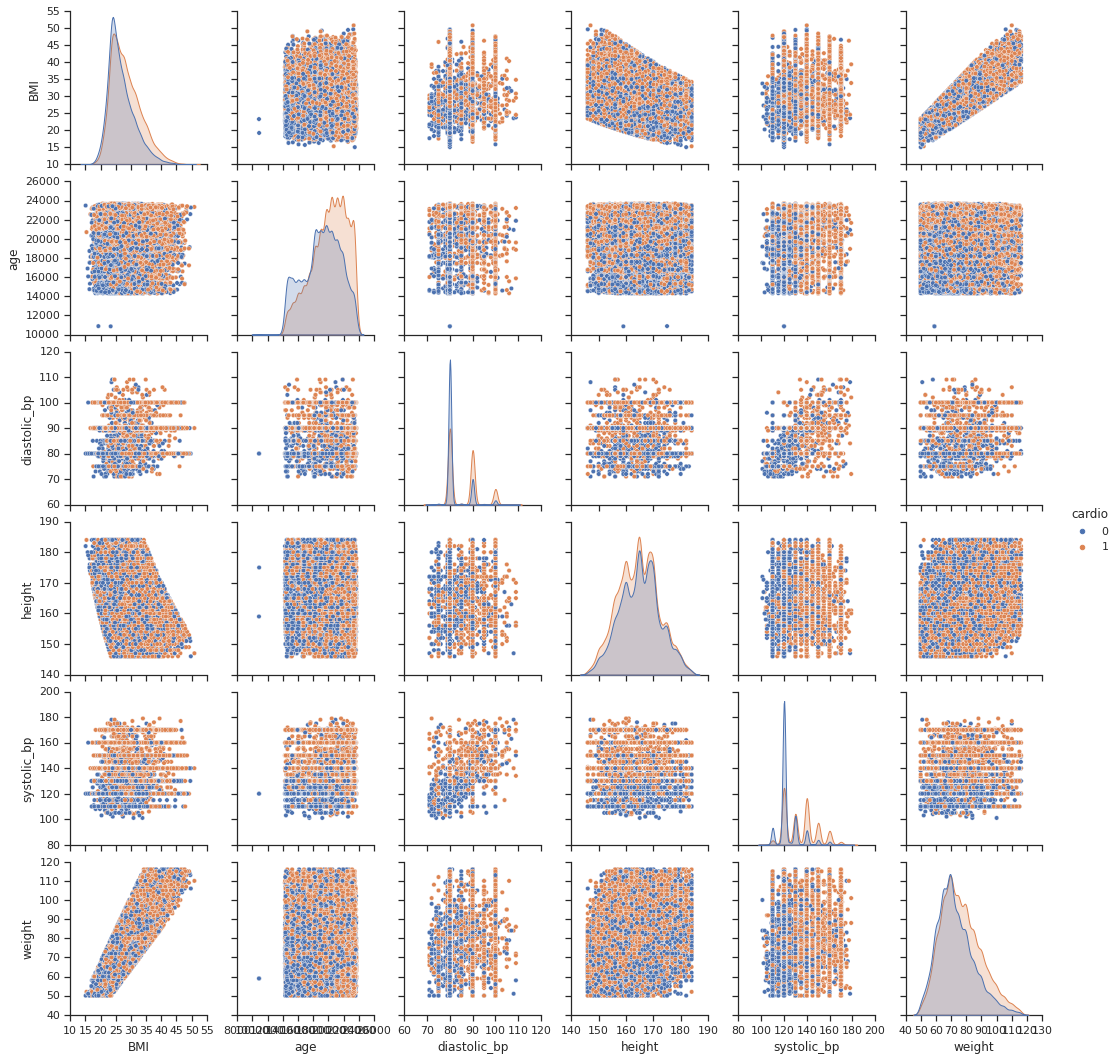

In [ ]:
#you can skip it, it takes time
sns.set_theme(style="ticks")
sns.color_palette("Paired")
sns.pairplot(cardio_df[cardio_df.columns.difference(['alco','smoke','active'])], hue="cardio")

We will attempt regression anyway

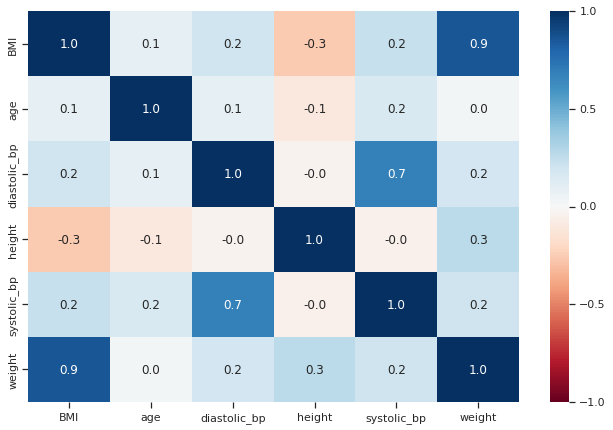

In [ ]:
cardio_corr = cardio_df[cardio_df.columns.difference(['alco','smoke','active','cardio'])].corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(cardio_corr, annot=True , fmt =".1f", cmap="RdBu", center=0, ax=ax,vmin=-1,
vmax =1)
plt.show()

In [ ]:
# #using only random 1000 records 
# sample_df = cardio_df.sample(n=1000,random_state=1)


## Regression

Turning categorical values into dummy variables

In [ ]:
predictors = ['age',"BMI","smoke","alco","gender","cholesterol","gluc", "active" ]
outcome = 'systolic_bp'
X = pd.get_dummies(cardio_df [predictors], drop_first=True) 
y=cardio_df[outcome]

X.head(4)

,age,BMI,smoke,alco,active,gender_male,cholesterol_normal,cholesterol_well above normal,gluc_normal,gluc_well above normal
id,,,,,,,,,,
0,50.0,21.97,0,0,1,1,1,0,1,0
1,55.0,34.93,0,0,1,0,0,1,1,0
3,48.0,28.71,0,0,1,1,1,0,1,0
8,60.0,29.38,0,0,0,0,0,0,0,0


#### Model training
Split dataset into trining and testing data, where test will be 40% of data and run multivariable linear regression algorithm  on training data

In [ ]:
# Split the data into training and validation
train_X, valid_X , train_y , valid_y = train_test_split (X, y, test_size=0.4 , random_state =1)
# Built the Linear Model based on the training data
cardio_lm = LinearRegression()
cardio_lm.fit(train_X , train_y)

# print coefficients
print(pd.DataFrame ({'Predictor': X.columns , 'coefficient': cardio_lm.coef_}))
print("Min and max training outcome value", train_y.min(),train_y.max())     
# print performance measures (training data)
regressionSummary(train_y, cardio_lm.predict(train_X))


                       Predictor  coefficient
0                            age     0.250675
1                            BMI     0.543591
2                          smoke     0.736624
3                           alco     0.511219
4                         active     0.377865
5                    gender_male     1.468063
6             cholesterol_normal    -4.654735
7  cholesterol_well above normal     0.360259
8                    gluc_normal    -1.185754
9         gluc_well above normal    -2.708543
Min and max training outcome value 101 178

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 12.6451
            Mean Absolute Error (MAE) : 10.1760
          Mean Percentage Error (MPE) : -0.8874
Mean Absolute Percentage Error (MAPE) : 7.6948


In [ ]:
# coefficient of determination
cardio_lm.score(X, y)

0.09889068323300665

The model explains only 9.9% of the variance in systolic_bp. This indicates that the model is not a good fit for the data, as it explains only a small fraction of the variability in the dependent variable.

We will follow the slides and test model on the validation dataset

#### Model test


In [ ]:
#testing our model
# Use predict() to make predictions on a new set predict using validation
cardio_lm_pred = cardio_lm.predict(valid_X)
result =pd.DataFrame ({'Predicted': cardio_lm_pred, 'Actual': valid_y, 'Residual': valid_y - cardio_lm_pred})
print(result.head ())
#print performace measures(validation data)
regressionSummary(valid_y , cardio_lm_pred)

        Predicted  Actual   Residual
id                                  
53355  136.068564     140   3.931436
40396  128.435568     120  -8.435568
21954  121.860061     120  -1.860061
72519  129.610477     140  10.389523
71121  135.471032     140   4.528968

Regression statistics

                      Mean Error (ME) : 0.2037
       Root Mean Squared Error (RMSE) : 12.7347
            Mean Absolute Error (MAE) : 10.1978
          Mean Percentage Error (MPE) : -0.7405
Mean Absolute Percentage Error (MAPE) : 7.6825


In [56]:
(12.7347/68.2)*70

13.070806451612903

#### Validation Performance

Assuming that the errors are normally distributed, the range of the errors within plus/minus one RMSE from the mean is roughly 68.2% of the total errors, within plus/minus two RMSEs is roughly 95%, and within plus/minus three RMSEs is roughly 99%. 

id
53355     3.931436
40396    -8.435568
21954    -1.860061
72519    10.389523
71121     4.528968
37558    -5.116969
32469    -5.149584
98753    -8.901014
45855    -9.184561
Name: systolic_bp, dtype: float64
The percentage of datapoints within plus or minus 13 value accuracy is  0.7396195442255697


<function matplotlib.pyplot.show(close=None, block=None)>

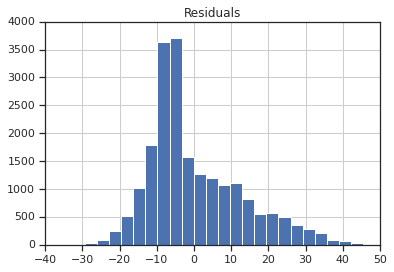

In [57]:
# Predictive accuracy measures and charts of prediction error distribution
# Validation Error - Evaluate Perfomance
all_residuals = valid_y - cardio_lm_pred

#Print top 9 observations of all_residuals
print(all_residuals.head(9))

# Determine the percentage of datapoint with a residual in [-13, 13] = approx. 75%
print("The percentage of datapoints within plus or minus 13 value accuracy is ", len(all_residuals[(all_residuals > - 13) & ( all_residuals < 13)]) / len(all_residuals))

pd.DataFrame({'Residuals': all_residuals }).hist(bins=25)
plt.show


The distribution of the residuals is positively skewed, which means we have more negative residuals, our model overestimates blood pressure more frequently than underestimates. On the other hand, we have large positive residuals (under-predictions) of 40-50 mmHg

A histogram of the residuals shows
that most of the errors are between ± $30 mmHg

## Variable Selection

#### Exhaustive search 
Exhaustive search for the “best” subset of predictors by fitting regression modules with all the possible
combinations of predictors.
Exhaustive search finds model using Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)

In [60]:
#Exhaustive approach

def train_model (variables):
    model = LinearRegression()
    model.fit(train_X [list (variables)], train_y)
    return model

def score_model (model,variables):
    pred_y = model.predict (train_X [list(variables)])
    return -adjusted_r2_score( train_y, pred_y,model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = list(result['variables'])
    AIC = AIC_score (train_y, model.predict (train_X [variables]), model)
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC':AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
    
pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple (sorted (allVariables)))

,n,r2adj,AIC,BMI,active,age,alco,cholesterol_normal,cholesterol_well above normal,gender_male,gluc_normal,gluc_well above normal,smoke
0,1,0.050650,247391.278680,True,False,False,False,False,False,False,False,False,False
1,2,0.077707,246493.982903,True,False,False,False,True,False,False,False,False,False
2,3,0.091902,246013.120728,True,False,True,False,True,False,False,False,False,False
3,4,0.095394,245894.427699,True,False,True,False,True,False,True,False,False,False
4,5,0.096309,245863.968272,True,False,True,False,True,False,True,False,True,False
5,6,0.096751,245849.773144,True,False,True,False,True,False,True,True,True,False
6,7,0.097028,245841.260285,True,False,True,False,True,False,True,True,True,True
7,8,0.097131,245838.708911,True,True,True,False,True,False,True,True,True,True
8,9,0.097167,245838.463489,True,True,True,True,True,False,True,True,True,True
9,10,0.097178,245839.108513,True,True,True,True,True,True,True,True,True,True


Non of the sets of variables gives us the result better then combined if we use measurement of model fit 
Adjusted $R^2 = 0.097178$

The AIC penalizes models with more parameters. Adding additional parameters does not essentially increase the informativeness of the model, so the best model will be just using one predictor - BMI

#### Backward Elimination
1. Start with a multiple regression model that includes all independent variables.

2. Calculate the p-values for each variable in the model using a significance level (e.g., 0.05). The p-value represents the probability that the variable has no effect on the dependent variable.

3. If the p-value of a variable is greater than the significance level, remove the variable from the model.

4. Re-estimate the regression coefficients and p-values for the remaining variables.

5. Repeat steps 3 and 4 until all remaining variables have p-values less than the significance level.


In [58]:
#Backward Elimination

def train_model (variables):
    model = LinearRegression()
    model.fit(train_X [list(variables)], train_y)
    return model

def score_model (model, variables):
    return AIC_score(train_y , model.predict (train_X [variables]), model)

allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, train_model,
                                                   score_model, verbose=True)

print (best_variables)

regressionSummary (valid_y, best_model.predict (valid_X [best_variables]))

Variables: age, BMI, smoke, alco, active, gender_male, cholesterol_normal, cholesterol_well above normal, gluc_normal, gluc_well above normal
Start: score=245839.11
Step: score=245838.46, remove cholesterol_well above normal
Step: score=245838.46, remove None
['age', 'BMI', 'smoke', 'alco', 'active', 'gender_male', 'cholesterol_normal', 'gluc_normal', 'gluc_well above normal']

Regression statistics

                      Mean Error (ME) : 0.2036
       Root Mean Squared Error (RMSE) : 12.7347
            Mean Absolute Error (MAE) : 10.1967
          Mean Percentage Error (MPE) : -0.7406
Mean Absolute Percentage Error (MAPE) : 7.6819


 Backward elimination suggests remove dummy "cholesterol_well above normal" which will increase AIC score. This does not descrease the error essentiallly 

#### Forward Selection
1. Start with a null model that includes no independent variables.

2. Select the independent variable that has the strongest correlation with the dependent variable and add it to the model.

3. Calculate the p-value for the added variable using a significance level (e.g., 0.05). If the p-value is less than the significance level, the variable remains in the model. Otherwise, remove the variable and stop the procedure.

4. Add the next independent variable that has the strongest correlation with the dependent variable and repeat step 3.

5. Continue adding variables and testing their significance until all variables have been added or no additional variables can be added that are statistically significant.

In [ ]:
# Forward Selection

def train_model (variables):
    if len (variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X [list(variables)], train_y)
    return model

def score_model (model, variables):
    if len (variables) == 0:
        return AIC_score (train_y, [train_y.mean ()] * len (train_y), model, df=1)
    return AIC_score (train_y , model.predict (train_X [variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)
print (best_variables)

Variables: age, smoke, alco, active, gender_male, cholesterol_normal, cholesterol_well above normal, gluc_normal, gluc_well above normal
Start: score=4643.47, constant
Step: score=4616.50, add cholesterol_normal
Step: score=4602.21, add age
Step: score=4591.75, add gluc_well above normal
Step: score=4591.75, add None
['cholesterol_normal', 'age', 'gluc_well above normal']


According to this model we should chose cholesterol_normal', 'age', 'gluc_well above normal" two of them are dummies, so we should include all cholesterol and gluc

#### Stepwise regression

In [ ]:
#Stepwise

best_model, best_variables = stepwise_selection (train_X.columns, train_model, score_model,verbose=True)
print(best_variables)

Variables: age, smoke, alco, active, gender_male, cholesterol_normal, cholesterol_well above normal, gluc_normal, gluc_well above normal
Start: score=4643.47, constant
Step: score=4616.50, add cholesterol_normal
Step: score=4602.21, add age
Step: score=4591.75, add gluc_well above normal
Step: score=4591.75, unchanged None
['cholesterol_normal', 'age', 'gluc_well above normal']
